## 1. generiranje korisnika slučajnom šetnjom

___________________________________________________

In [ ]:
ID=7
#hop_alpha = 2

MAX_HOPS_DIFF = 6 #udaljenost od pozitivnih
MIN_HOPS_DIFF = 2
NUM_HARD_NEG = 3
NUM_EASY_NEG = 3


MIN_CLANAKA = 6 
MAX_CLANAKA = 10
BROJ_JEZGRI=16
BROJ_KORISNIKA=300_000

MAX_DEGREE=100 #uklanjamo sve vrhove koji imaju stupanj veći od MAX_DEGREE 
BROJ_KORISNIKA_PO_JEZGRI=BROJ_KORISNIKA//BROJ_JEZGRI + 1



____

In [ ]:
%run helper_notebooks/random_walk_tuned.ipynb

info o grafu citata

In [ ]:
print("broj vrhova, broj bridova\n",maxG.summary())
print("medijan stupnja vrhova",mean(maxG.degree()))

__________

## .. 👽   

In [ ]:
%run helper_notebooks/random_walk_version_dropdown.ipynb

In [ ]:
VERSION


____________

In [ ]:
%run helper_notebooks/imports.ipynb #importa sve potrebne module

In [ ]:
%run helper_notebooks/userArticleLabel_dataset.ipynb


dalje, embeddamo korisnike uz fasttext & transformer

In [ ]:
%run helper_notebooks/userVect_dataset.ipynb 

In [ ]:
%notify

🍓 sljedeća čelija oslobađa svu zauzetu memoriju do sada

In [ ]:
#izbriši me
#%reset -f

# 2. Triplet model - cijeli notebook 

### ! importanje potrebnih modula

In [1]:
BATCH_SIZE=64
LR=0.001
DROPOUT=0.2

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [1]:
%run helper_notebooks/imports.ipynb #importa sve potrebne module

In [4]:
from helper_notebooks.triplet_data_generator import DataGenerator #generator podataka za trening,validaciju

_____________________________________________________________________________________________________________

# !
###  👽 ukoliko se mijenjala arhitektua TT ali ne i korisnici, izmjeniti naziv modela ovdje

In [5]:
MODEL_VERSION_NAME=str(BATCH_SIZE)+"_"+str(LR) #IZMIJENI ME

🍓 👽 pokreće se zadnja konfiguracija korisnika - može se izmijeniti i zatim -> run all below

In [6]:
%run helper_notebooks/random_walk_version_dropdown.ipynb

interactive(children=(Dropdown(description='verzija korisnika:', options=('6-10-200000-100_ID@_4', '6-10-30000…

In [7]:
VERSION

'5-8-300000-100_ID@_1'

# BIRAJ TT ILI Triplet


In [8]:
TRIPLET = True

___________________________________________________________________________________________________________

# BIRAJ TT- FASTTEXT ILI TRANSFORMER  (bert)

In [9]:
TRANSFORMER = True # PROMIJENI AKO ŽELIŠ TRANSFORMERA

____

In [10]:
MODEL_VERSION_NAME=MODEL_VERSION_NAME+'@'+datetime.datetime.now().strftime("%m%d-%H%M%S") #extra precaution (:

In [11]:
PATH="datasets/master_generated/"+VERSION+"/"
SAVE_PATH=PATH+'MODELS/'+MODEL_VERSION_NAME+'/'

additional="tt_"
if TRIPLET:
    additional="triplet_"
IDS_PATH=glob.glob(PATH+additional+"*Label*")[0]

USER_VECT_PATH = glob.glob(PATH+'*userVect*')[0]
CKPT_PATH=SAVE_PATH+MODEL_VERSION_NAME+"_CKPT" #model checkpoint path

In [12]:
ids_labels_df =pd.read_parquet(IDS_PATH)

In [13]:
ids_labels_df.head(2)

,userID,posID,negID
0,0,53e9b173b7602d9703bf874f,53e9be6bb7602d9704b2c654
1,0,53e9b173b7602d9703bf874f,53e99df7b7602d97026b820e


In [14]:
try:
    article_vect_dict
except:
    if not TRANSFORMER: #FastText
        article_vect_dict =pd.read_parquet('datasets/dblpv13_fasttext.parquet',  engine='pyarrow').set_index('id').T.to_dict('list') 
        article_vect_dict = {key: np.vstack(value) for key, value in article_vect_dict.items()} # "unpack" vectors
    else: #SenBert transformer
        article_vect_dict_tr_part1 =pd.read_parquet('datasets/mLM_part_1',  engine='pyarrow').set_index('id').T.to_dict('list') 
        article_vect_dict_tr_part1 = {key: np.vstack(value) for key, value in article_vect_dict_tr_part1.items()} # "unpack" vectors
        article_vect_dict_tr_part2 =pd.read_parquet('datasets/mLM_part_2',  engine='pyarrow').set_index('id').T.to_dict('list') 
        article_vect_dict_tr_part2 = {key: np.vstack(value) for key, value in article_vect_dict_tr_part2.items()} # "unpack" vectors
        article_vect_dict = {**article_vect_dict_tr_part1, **article_vect_dict_tr_part2}

In [15]:
input_shape=article_vect_dict['558b49f984ae84d265c28c14'].shape[1]
input_shape

384

In [16]:
user_vect_dict=pd.read_json(USER_VECT_PATH).set_index('userID').T.to_dict('list') 
user_vect_dict = {key: np.vstack(value[int(TRANSFORMER)]) for key, value in user_vect_dict.items()}
#user_vect_dict = {key: np.vstack(value) for key, value in user_vect_dict.items()}

In [17]:
print("Number of users:",len(user_vect_dict),"\nNumber of  articles:", len(article_vect_dict),"\nNumber of user-article-label pairs: ",len(ids_labels_df))

Number of users: 300016 
Number of  articles: 3851441 
Number of user-article-label pairs:  9909678


In [18]:
uni = set(ids_labels_df['posID'])
uni.update(ids_labels_df['negID'])
print("Number of unique articles:",len(uni))

Number of unique articles: 1861817


In [19]:
def split(X, test_size): #splitting dataset to train, test, validate set
    gs = GroupShuffleSplit(n_splits=10, #num of re-shuffling
                            test_size=test_size,
                            random_state=42,
                            )
    train_ix, test_ix = next(gs.split( X, groups=X['userID'])) #one user in only one dataset (train or test or validate)
    df_train = X.loc[train_ix]
    df_test = X.loc[test_ix]
    
    
    return df_train, df_test
    


In [20]:
def shuffle(x): #shuffle dataset
    idx = np.random.permutation(x.index)
    x = x.reindex(idx)
    x.reset_index(drop=True, inplace=True) #reset indexes     
    return x   
    

In [21]:
df_train, df_test = split(ids_labels_df, 0.2)
df_test.reset_index(drop=True, inplace=True) #reset indexes     
df_test, df_val  = split(df_test, 0.5)

In [22]:
df_train=shuffle(df_train)
df_test=shuffle(df_test)
df_val=shuffle(df_val)

In [23]:
print("size of training set:",len(df_train),"\nsize of validation set:",len(df_val),"\nsize of test set:",len(df_test))

size of training set: 7927992 
size of validation set: 990132 
size of test set: 991554


In [24]:
df_train.head()

,userID,posID,negID
0,213738,53e9bb29b7602d97047651c7,53e9b81cb7602d97043d3c5b
1,295981,5550450f45ce0a409eb5346c,5ecce8d991e0119170395b25
2,290433,53e9a1bdb7602d9702ab6473,53e9adbdb7602d97037bd2c7
3,32602,53e9a570b7602d9702e9a678,53e9abdab7602d970358f4bf
4,274920,56d8fa39dabfae2eeeae1d72,558a49a9e4b0b32fcb35eda5



________________________________________________________________________________________________
mariniranje skupa za trening je gotovo, bacamo se na definiranje fja za treniranje

prve dvije čelije su za learning rate finder

In [25]:
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 1/5
    else:
        return lr 

In [26]:
training_generator =DataGenerator(df_train, article_vect_dict, user_vect_dict,dim=input_shape, batch_size=BATCH_SIZE)
validation_generator = DataGenerator(df_val, article_vect_dict, user_vect_dict, dim=input_shape, batch_size=BATCH_SIZE)
testing_generator = DataGenerator(df_test, article_vect_dict, user_vect_dict,dim=input_shape, batch_size=BATCH_SIZE,shuffle=False)

 #### 🐟 tri čelije ispod se ne koriste ukoliko se koristi tensorboard hparam tuning 

In [2]:
def one_tower():    
    input=layers.Input(input_shape)
    x=layers.BatchNormalization()(input)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(250)(x)
    x=layers.Activation('relu')(x)
    
    x=layers.BatchNormalization()(input)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(200)(x)
    x=layers.Activation('relu')(x)
    
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(150)(x)
    x=layers.Activation('relu')(x)
    
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(100)(x)
    x=layers.Activation('relu')(x)


    

    
    embedding_network = keras.Model(input, x)
    return embedding_network


In [3]:
def triplet_loss(y_true, y_pred, alpha = 0.1):
    total_lenght = y_pred.shape.as_list()[-1]


    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    distance1 = tf.keras.losses.cosine_similarity(anchor, positive)
    distance2 = tf.keras.losses.cosine_similarity(anchor, negative)
    return tf.keras.backend.clip(distance1 - distance2 + alpha, 0., None)

In [8]:
#cosine TRIPLET
user_input = Input(shape=input_shape)
article_pos_input = Input(shape=input_shape)
article_neg_input = Input(shape=input_shape)



shared_tower=one_tower()

user_output=shared_tower(user_input)
article_pos_output=shared_tower(article_pos_input)
article_neg_output=shared_tower(article_neg_input)

merged_vector = tf.keras.layers.concatenate([user_output, article_pos_output, article_neg_output], axis=-1)

In [11]:
opt = keras.optimizers.Adam(learning_rate=LR) #clipvalue?


#model = Model([user_input, article_input], prediction)
#loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),


model = Model(inputs=[user_input,article_pos_input, article_neg_input], outputs=merged_vector)


model.compile(optimizer=opt,
              loss=triplet_loss,
              #metrics=accuracy,
              run_eagerly=False)

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 100)          108050      input_5[0][0]                    
                                                                 input_6[0][0]              

In [13]:
tf.keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [33]:
#optimal learning rate
# ! trening modela 

#find_lr(model, training_generator, len(df_train), batch_size=BATCH_SIZE) 

In [34]:
#STOP

___

🍓 brisanje logova - TensorBoard

In [35]:
#%reload_ext tensorboard

____

### 🐟 🐟 🐟 teretana (bez hparam tuninga) 

In [36]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, #train i val acc&loss
                                                      histogram_freq=4,
                                                      profile_batch=0) # ovo uklanja ružnjikave ispise tokom fit metode



stopper_callback = tf.keras.callbacks.EarlyStopping(  
                       monitor='loss', 
                       patience=7,
                       min_delta=0.0001, 
                       restore_best_weights=True                   
                       ) 




lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)







#ckpt_callback = tf.keras.callbacks.ModelCheckpoint( # ¬lijepi ispisi
#                                      CKPT_PATH,
#                                      monitor='val_loss',
#                                      mode='auto',
#                                      save_weights_only=False,
#                                      save_best_only=False,
#                                      save_freq=30) 


In [37]:
#%tensorboard --logdir logs/fit

In [38]:
history=model.fit(training_generator,
          validation_data=validation_generator,
          callbacks=[#tensorboard_callback,  # log metrics
                     lr_callback,
                 #    hp.KerasCallback(logdir, hparams),  # log hparams
                     stopper_callback
          ],
                    #ckpt_callback],     
          epochs=80
          )

Epoch 1/80
123874/123874 [==============================] - 239s 2ms/step - loss: 0.0376 - val_loss: 0.0329
Epoch 2/80
123874/123874 [==============================] - 240s 2ms/step - loss: 0.0349 - val_loss: 0.0324
Epoch 3/80
123874/123874 [==============================] - 240s 2ms/step - loss: 0.0343 - val_loss: 0.0322
Epoch 4/80
123874/123874 [==============================] - 240s 2ms/step - loss: 0.0339 - val_loss: 0.0320
Epoch 5/80
123874/123874 [==============================] - 241s 2ms/step - loss: 0.0337 - val_loss: 0.0318
Epoch 6/80
123874/123874 [==============================] - 241s 2ms/step - loss: 0.0335 - val_loss: 0.0318
Epoch 7/80
123874/123874 [==============================] - 240s 2ms/step - loss: 0.0333 - val_loss: 0.0317
Epoch 8/80
123874/123874 [==============================] - 240s 2ms/step - loss: 0.0332 - val_loss: 0.0316
Epoch 9/80
123874/123874 [==============================] - 241s 2ms/step - loss: 0.0331 - val_loss: 0.0316
Epoch 10/80
123874/123874 [=

#### evaluacija modela  

## 🎣

### Confusion matrix, roc auc, f1


## 3.  Testiranje da li su se pozitivni približili i negativni udaljili

In [39]:
user_tower=article_tower=shared_tower

In [40]:
MODEL_VERSION_NAME

'64_0.001@0624-190014'

In [41]:
user_tower.save(SAVE_PATH+'shared_tower_'+MODEL_VERSION_NAME+'.h5') 
#article_tower.save(SAVE_PATH+'itemTower_'+MODEL_VERSION_NAME+'.h5')
model.save(SAVE_PATH+'model_'+MODEL_VERSION_NAME+'.h5')

## 4. Metrika twitter korisnika

model iz sesije
avg user cossim median for positive example [MODEL]:  0.7630159
avg user cossim median for positive example:  0.4734716
avg user cossim median for negative example [MODEL]:  0.42115095
avg user cossim median for negative example:  0.15610409


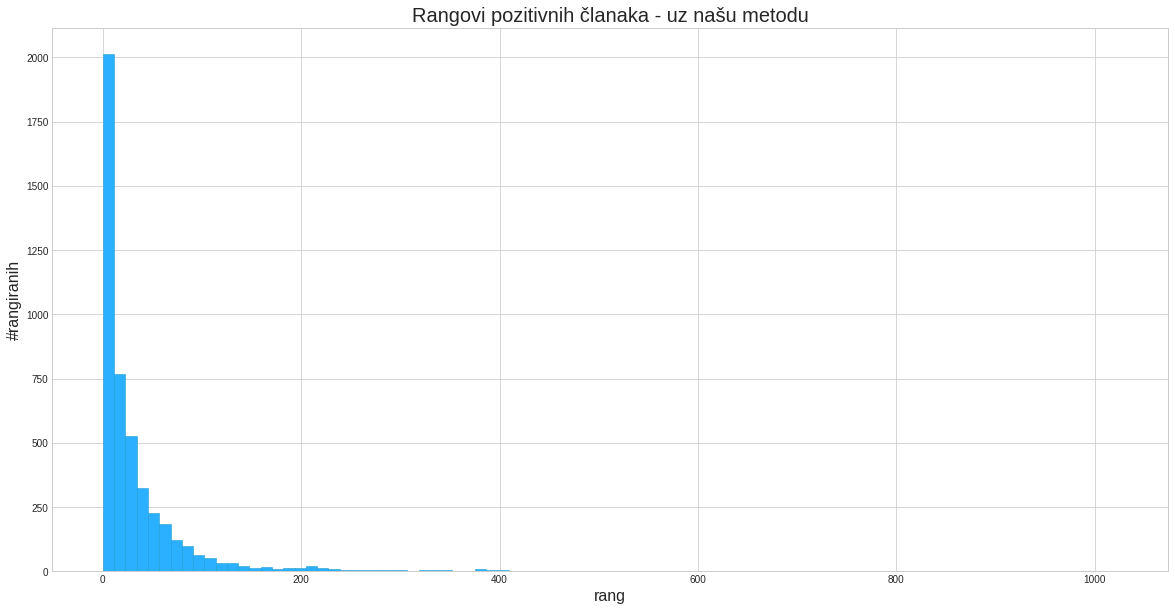

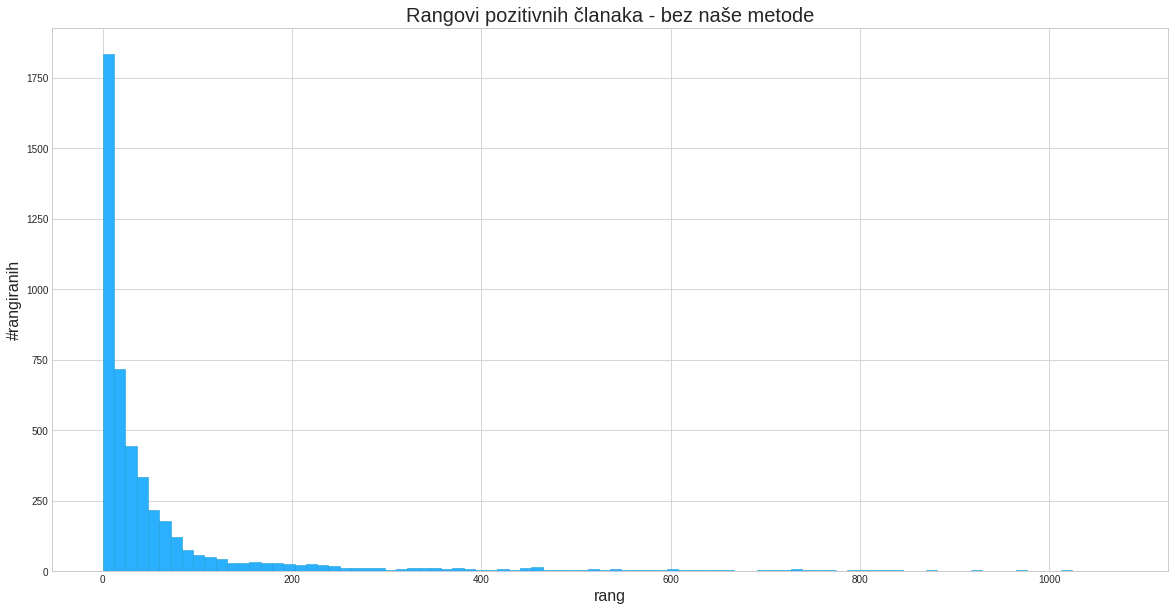

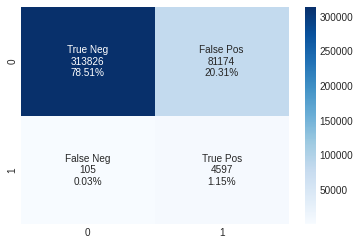

sveukupno imamo 4702 pozitivnih članaka i 413 korisnika
prepoznato 97.76690769885155% pozitivnih članaka
ACC: 0.7966510049987241
roc-auc: 0.8860826397600806
F1 - macro: 0.4934856961988077
F1 - micro: 0.7966510049987241
P@k; k=1
model-mean for all users: 0.7341772151898734
non-model-mean for all users: 0.7063291139240506
P@k; k=3
model-mean for all users: 0.6666666666666667
non-model-mean for all users: 0.6426160337552742

nDCG:
model-mean for all users: 0.7990775713203333
non-model-mean for all users: 0.7580852521325455
395
>>>>>>>>>>>> delta rank 1=  0.027848101265822822


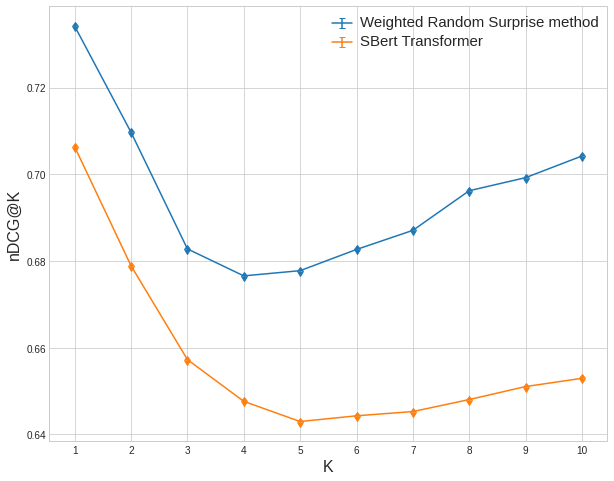

In [42]:
%run helper_notebooks/twitter_ranking.ipynb

In [43]:
%notify

<IPython.core.display.Javascript object>

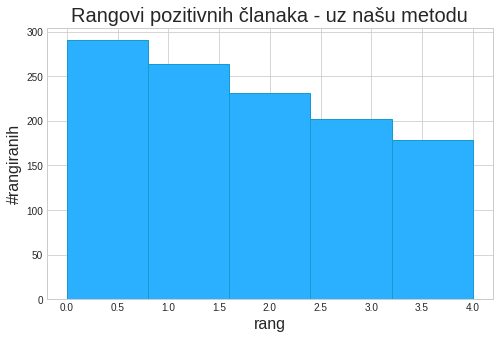

In [44]:
ranks = [r for sublist in user_ranks_m for r in sublist if r < 5] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - uz našu metodu',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.savefig(SAVE_PATH + 'top_5.png')
plt.show()


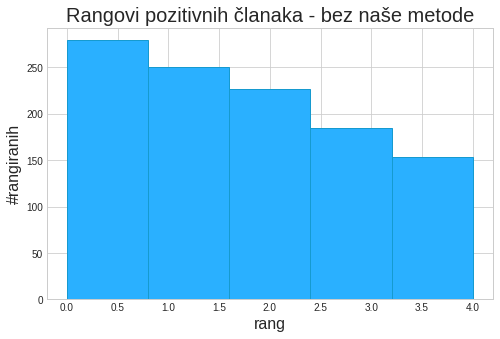

In [45]:
ranks = [r for sublist in user_ranks_p for r in sublist if r < 5] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - bez naše metode',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.savefig(SAVE_PATH + 'top_5_bez_nase.png')

plt.show()
plt.close()

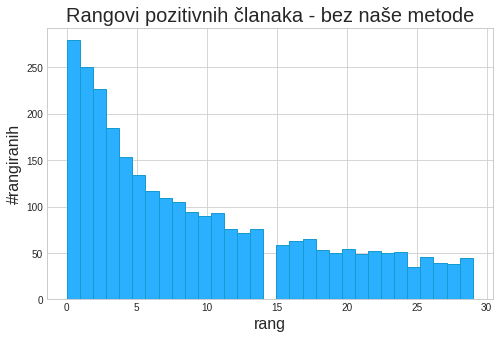

In [46]:
ranks = [r for sublist in user_ranks_p for r in sublist if r < 30] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=31, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - bez naše metode',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.show()

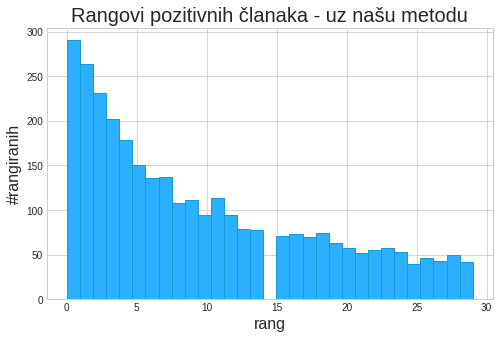

In [47]:
ranks = [r for sublist in user_ranks_m for r in sublist if r < 30] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=31, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - uz našu metodu',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.show()